# Model creation on San Francisco Crime Data

To give an introduction this is the second notebook on the model deployment process that I will try to achieve . We initially did some data exploration to remove outliers and process data and save the processed data for further usage. <a href="https://github.com/ankur26/SFCrimePrediction/blob/master/notebooks/01_data_exploration_and_feature_engineering.ipynb">Link to first notebook </a>

This notebook will entail the model creation process and we will find the best fitting model



In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv("/root/SFCrimePrediction/data/processed/train_processed.csv")
test_data = pd.read_csv("/root/SFCrimePrediction/data/processed/test_processed.csv")

In [3]:
train_data.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
test_data.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
train_features = train_data.drop("Category",axis=1).fillna("N/A")
test_data.fillna("N/A",inplace=True)
train_target = train_data["Category"]

In [6]:
features = train_features.dtypes.reset_index()

In [7]:
cat_features = features.loc[features[0] == "object","index"].values

In [8]:
from catboost import *

In [9]:
params = {}
params["loss_function"] = "MultiClass"
params["iterations"] = 1000
params["learning_rate"] = 0.01
params["task_type"] = "GPU"
params["depth"] = 10
# params["save_snapshot"] = True
# params["snapshot_interval"] = 1200


In [10]:
# cv_data  = cv(
#             params=params,
#             pool = Pool(data=train_features,label=train_target,cat_features=cat_features),
#             shuffle=True,
#             fold_count=5,
#             stratified=True,
#             verbose=100)

The metric in the competition used is called as multi class logarithmic loss which basically entails the probability of the crime happening to you.
So for example we have a set of four crimes namely 1,2,3,4 and so the output for crime 1 should be a vector [1,0,0,0] as we know that the probability of crime 1 occuring is 1 and if our predicted outcome is [0.8,0.2,0.0] the model predicted that the outcome for crime 1 is 0.8 (80% percent chance of crime 1) and crime 2 is 0.2 (20% of chance of crime 2).

So the log loss will be calculated as the sum (output * log(probabilities)) which is then normalized across all samples by dividing by the sample size.

For further detail here is the link : <a href="https://www.kaggle.com/wiki/MultiClassLogLoss"> Multi Class Log Loss</a>


In [12]:
params["iterations"] =2000

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_features,train_target)

In [15]:
classifier = CatBoost(params=params)

In [17]:
classifier.fit(Pool(data=X_train,label=y_train,cat_features=cat_features),
              eval_set=Pool(data=X_test,label=y_test,cat_features=cat_features),use_best_model=True,
              verbose=200)

0:	learn: 3.6228874	test: 3.6229278	best: 3.6229278 (0)	total: 627ms	remaining: 20m 52s
200:	learn: 2.4214777	test: 2.4290825	best: 2.4290825 (200)	total: 1m 58s	remaining: 17m 40s
400:	learn: 2.3256640	test: 2.3431905	best: 2.3431905 (400)	total: 3m 57s	remaining: 15m 45s
600:	learn: 2.2877141	test: 2.3167411	best: 2.3167411 (600)	total: 5m 57s	remaining: 13m 53s
800:	learn: 2.2600450	test: 2.3011493	best: 2.3011493 (800)	total: 7m 59s	remaining: 11m 57s
1000:	learn: 2.2370170	test: 2.2902369	best: 2.2902369 (1000)	total: 10m 1s	remaining: 10m
1200:	learn: 2.2161556	test: 2.2818962	best: 2.2818962 (1200)	total: 12m 4s	remaining: 8m 2s
1400:	learn: 2.1972514	test: 2.2749698	best: 2.2749698 (1400)	total: 14m 6s	remaining: 6m 1s
1600:	learn: 2.1788332	test: 2.2685476	best: 2.2685476 (1600)	total: 16m 8s	remaining: 4m 1s
1800:	learn: 2.1609242	test: 2.2634415	best: 2.2634415 (1800)	total: 18m 12s	remaining: 2m
1999:	learn: 2.1442873	test: 2.2591125	best: 2.2591125 (1999)	total: 20m 15s	re

In [19]:
'''
Making a competition submission to see whether this model
could be a good stopping point or not
'''
test_id = pd.read_csv("/root/SFCrimePrediction/data/raw/test.csv")["Id"]

In [23]:
predictions = pd.DataFrame(classifier.predict(test_data,prediction_type="Probability"),columns=classifier.classes_)

In [24]:
predictions = pd.concat([test_id,predictions],axis=1)

In [25]:
predictions.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.003985,0.137738,0.000094,0.001086,0.028876,0.001407,0.004965,0.029807,0.004514,...,0.000102,0.010840,0.000352,0.064600,0.000152,0.003546,0.046819,0.133145,0.058355,0.052791
1,1,0.001582,0.058967,0.000069,0.000586,0.001033,0.001896,0.008009,0.099057,0.004761,...,0.000079,0.004242,0.000323,0.061761,0.000071,0.000346,0.020720,0.004919,0.096618,0.028967
2,2,0.003806,0.174157,0.000170,0.000340,0.083452,0.001650,0.003835,0.017128,0.006730,...,0.000075,0.012435,0.000611,0.037149,0.000046,0.010980,0.058228,0.030494,0.040852,0.007780
3,3,0.001853,0.181355,0.000224,0.000470,0.025382,0.003683,0.005211,0.060802,0.010493,...,0.000230,0.008231,0.000259,0.056876,0.000094,0.005124,0.063919,0.053306,0.074396,0.026193
4,4,0.001853,0.181355,0.000224,0.000470,0.025382,0.003683,0.005211,0.060802,0.010493,...,0.000230,0.008231,0.000259,0.056876,0.000094,0.005124,0.063919,0.053306,0.074396,0.026193


Now that we a have a prediction file, I will save it and make a submission to see whether it is a reasonable enough estimate for deploying the model.


In [26]:
predictions.to_csv("/root/SFCrimePrediction/data/processed/test_results.csv")

Now that the file has been evaluated it my Kaggle score on the leaderboard was 2.27 which is within the top 10% of candidates on the public leaderboard so we will give this model the final pass and save it off for further usage in deployment.

To verify here is the screenshot taken from Kaggle

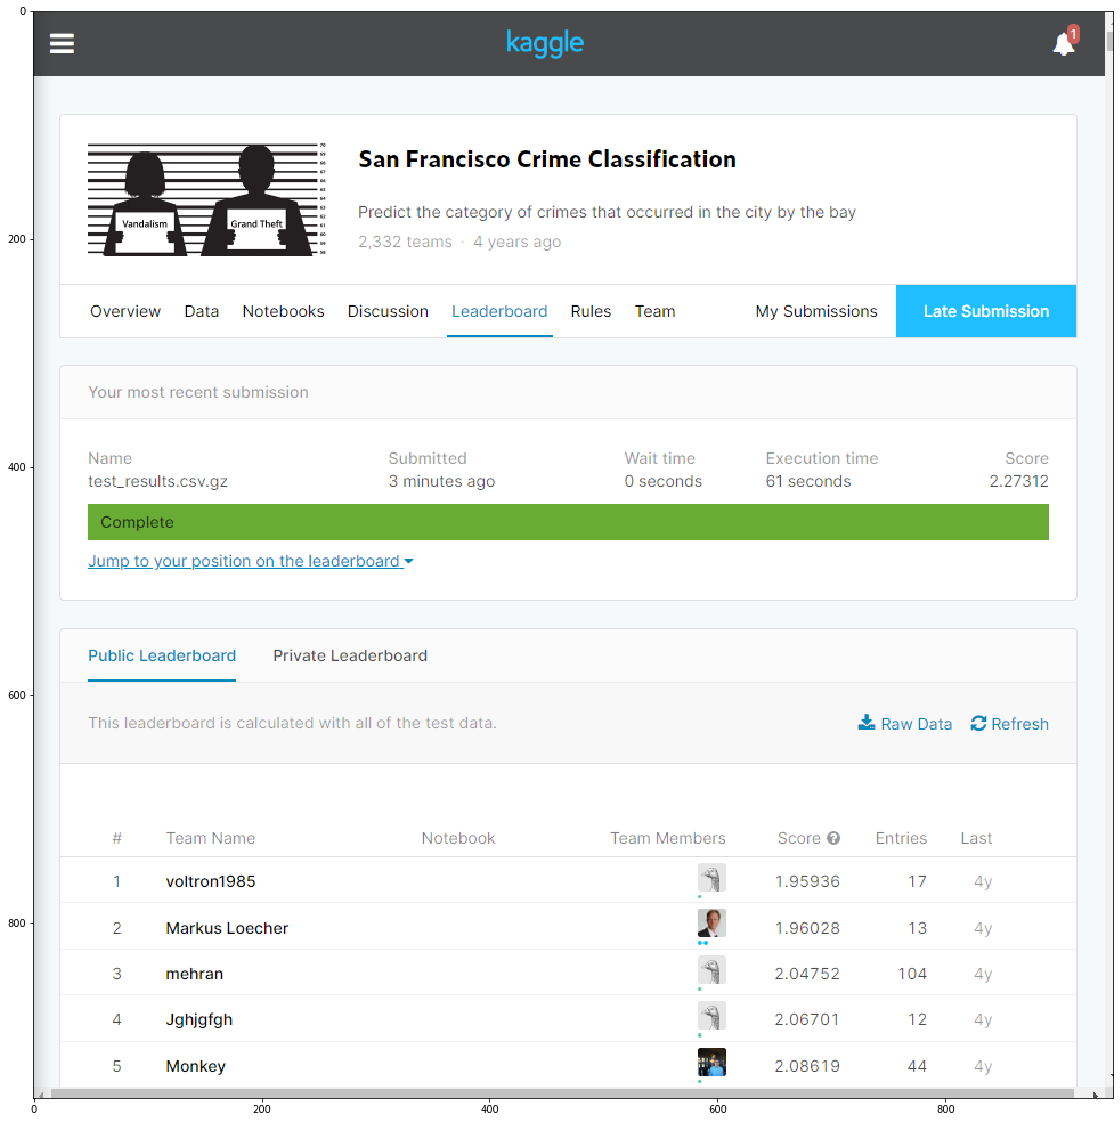

In [29]:
import matplotlib.pyplot as plt
score_img = plt.imread("score.PNG")
plt.figure(figsize=(20,20))
plt.imshow(score_img)

In [27]:
classifier.save_model("/root/SFCrimePrediction/models/final_model")

We have saved the model for further usage in the actual deployed version of our app. 

The next notebook will cover the front end for the process and how I will host the app and model which serves the app.

Libraries used: Catboost,sklearn,matplolib,pandas

Link for next notebook which is deployment process of models: <a href="">Link</a>